### <img src="Instacart_logo_small.png" alt="Instacart" style="width: 100px;"/>

# Recommend products to Instacart Customers

## Introduction

Recommendations can be done at different levels. 

In my previous notebook for Recommendations, I have tried **Cosine Similarity** and **ALS** Algorithms to recommend Products to Customers. 

In this notebook, I would like to try another approach. I want to classify the customers in different clusters and then Recommend Products based on the top 10 products from each cluster.  

The main objective of this notebook is **Customer Classifications** based on the features provided or added and then recommend products.

## Load Data

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.manifold import TSNE
import time

#### Import the final CSV file with added features

In [2]:
df_final = pd.read_csv("data_final.csv")
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22026608 entries, 0 to 22026607
Data columns (total 26 columns):
Unnamed: 0                int64
order_id                  int64
product_id                int64
add_to_cart_order         int64
reordered                 int64
product_name              object
aisle_id                  int64
department_id             int64
aisle                     object
dept_group                object
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    int64
order_size                int64
total_order_count         int64
loyal_customer            bool
days_order_span           float64
user_dept_count           int64
user_product_count        int64
weekend_buy               bool
preferred_hour            int64
is_organic                bool
prefers_organic           int64
dtypes: bool(3), float64(1), int64(18), object(4)


There are a few columns which are not that useful for recommending products to customers. So, first let's drop the not-so-useful columns and then take a look at our initial data.

In [3]:
df_data = df_final[['user_id',"dept_group","days_since_prior_order","order_size","total_order_count","loyal_customer","days_order_span","is_organic","user_dept_count","user_product_count","weekend_buy","preferred_hour","prefers_organic"]]
df_data = df_data.sort_values(['user_id'])
df_data.head()

,user_id,dept_group,days_since_prior_order,order_size,total_order_count,loyal_customer,days_order_span,is_organic,user_dept_count,user_product_count,weekend_buy,preferred_hour,prefers_organic
0,1,beverages,0,5,11,False,1248.0,False,15,11,False,1,0
50,1,beverages,30,9,11,False,1248.0,False,15,11,True,1,0
49,1,food,0,6,11,False,1248.0,False,51,10,False,2,0
48,1,food,0,6,11,False,1248.0,False,51,10,False,2,0
47,1,beverages,0,6,11,False,1248.0,False,15,11,False,2,0


#### Convert Boolean Features to Integer

In [4]:
df_data.loyal_customer = df_data.loyal_customer.astype('int')
df_data.is_organic = df_data.is_organic.astype('int')
df_data.weekend_buy = df_data.weekend_buy.astype('int')

In [5]:
df_data.shape

(22026608, 13)

In [6]:
print("Unique customer count: ", df_data.user_id.nunique() )

Unique customer count:  131209


Our current dataset has 22026608 records but if we check the unique customers count, it is 131209.Since, we are planning to classify customers, let's try to get a single record for each customer and then apply the customer classification algorithm.

## Prepare Data

#### Create a new dataframe with max values of some columns for each customer

In [7]:
df1 = df_data.groupby(["user_id"])[["weekend_buy","preferred_hour","prefers_organic","loyal_customer","days_order_span"]].max()
df1 = df1.reset_index()
df1.shape

(131209, 6)

#### Create a new dataframe with average values of some columns for each customer

In [8]:
df2 = df_data.groupby(["user_id"])[["days_since_prior_order","order_size","total_order_count"]].mean().round()
df2 = df2.reset_index()
df2.shape

(131209, 4)

#### Create a new dataframe with average values of quantities bought from each depeartment group

In [9]:
df3 = df_data.groupby(["user_id","dept_group"])[["user_dept_count"]].mean().round()
df3 = df3.reset_index()
df3.loc[df3.user_dept_count > 0, "value_present"] = 1
df3[df3.user_id == 1]

,user_id,dept_group,user_dept_count,value_present
0,1,beverages,15,1.0
1,1,food,51,1.0
2,1,household,3,1.0
3,1,pantry,1,1.0


#### Pivot Table to get each Department Group as a Column

In [10]:
df4 =  df3.pivot_table(index = "user_id",columns='dept_group', values = "user_dept_count", fill_value=0)
df4 =  df4.reset_index()
df4[df4.user_id == 1]

dept_group,user_id,alcohol,babies,beverages,food,household,international,other,pantry,personal-care,pets
0,1,0,0,15,51,3,0,0,1,0,0


#### Merge all the dataframes created above to get a singe dataframe with one row for each customer

In [11]:
df = pd.merge(df1,df2, on ='user_id')
df = pd.merge(df,df4, on ='user_id')
df.shape

(131209, 19)

Now, let's take a look at our current data where we have single row for each customer.

#### Rename Column

In [12]:
df.rename(columns={'personal-care':'personal_care'},inplace=True)

In [13]:
df.head(5)

,user_id,weekend_buy,preferred_hour,prefers_organic,loyal_customer,days_order_span,days_since_prior_order,order_size,total_order_count,alcohol,babies,beverages,food,household,international,other,pantry,personal_care,pets
0,1,1,2,0,0,1248.0,18.0,7.0,11.0,0,0,15,51,3,0,0,1,0,0
1,2,1,2,0,0,3836.0,17.0,18.0,15.0,0,0,9,201,0,3,0,11,2,0
2,5,1,3,1,0,431.0,9.0,10.0,5.0,0,0,0,38,1,4,0,3,0,0
3,7,1,3,0,0,2682.0,12.0,13.0,21.0,0,0,56,147,1,0,0,10,0,1
4,8,0,4,1,0,1020.0,15.0,17.0,4.0,0,0,0,62,0,1,0,4,0,0


Now, Let's take a look at the Continous Data Column

#### days_order_span

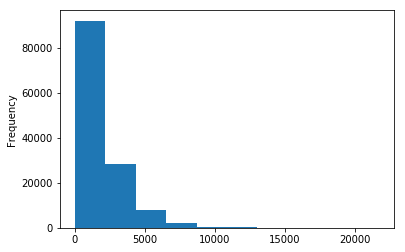

In [14]:
df.days_order_span.plot("hist")

**days_order_span** Column data varies largely from 0 to 21708 and the data is left skewed. This column data needs to be normalized.

#### days_since_prior_order

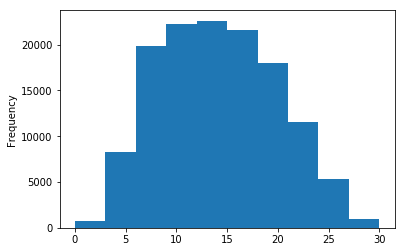

In [15]:
df.days_since_prior_order.plot("hist")

**days_since_prior_order** value seems normally distributed.

#### order_size

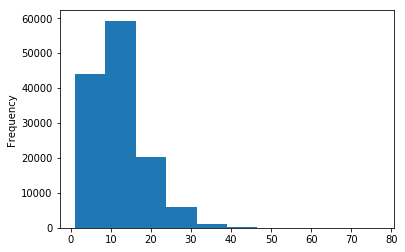

In [16]:
df.order_size.plot("hist")

**Order_size** varies from 1 to 77. But the data is left skewed.

#### total_order_count

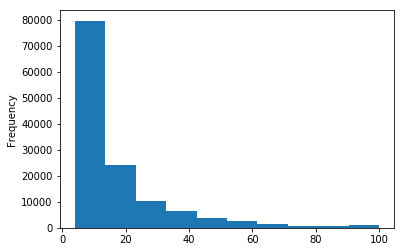

In [17]:
df.total_order_count.plot("hist")

**total_order_count** varies from 4 to 100. But the data is left skewed.

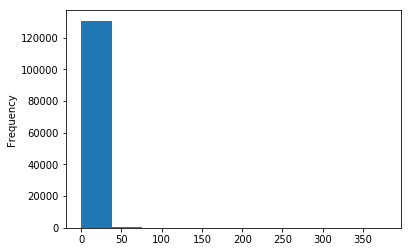

In [18]:
df.alcohol.plot("hist")

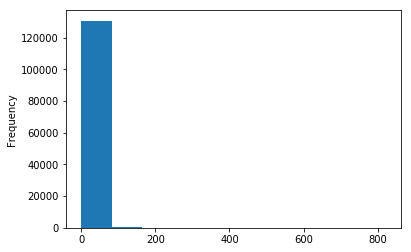

In [19]:
df.babies.plot("hist")

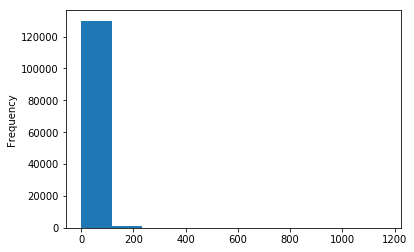

In [20]:
df.beverages.plot("hist")

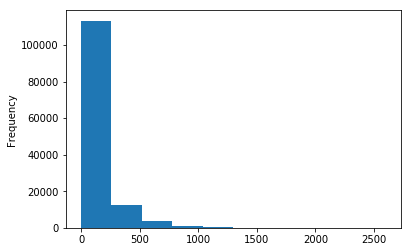

In [21]:
df.food.plot("hist")

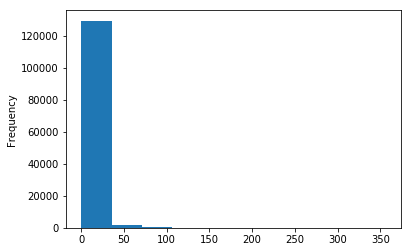

In [22]:
df.household.plot("hist")

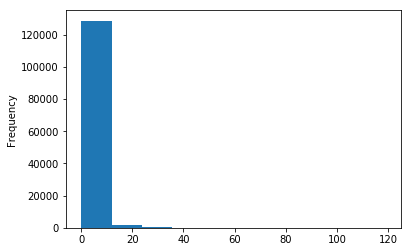

In [23]:
df.international.plot("hist")

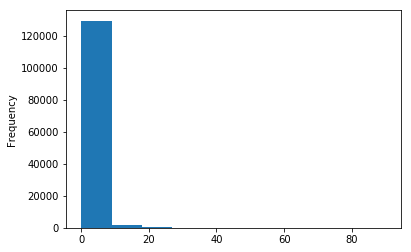

In [24]:
df.other.plot("hist")

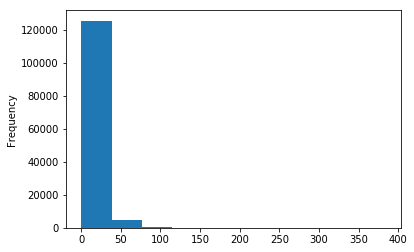

In [25]:
df.pantry.plot("hist")

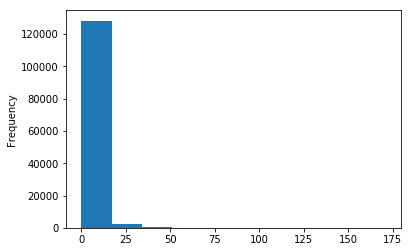

In [26]:
df.personal_care.plot("hist")

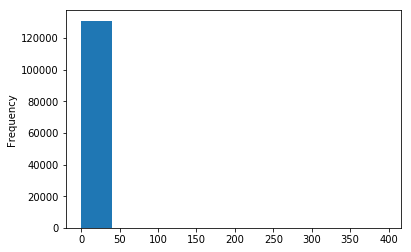

In [27]:
df.pets.plot("hist")

Most of the fetaures are left skewed and standarizing the data is essential. 

**Standardizing the Dataset** is important as the clustering algorithms depend on calculating distances between the observations. Due to different scales of measurement of variables, some variables may have higher influence on the clustering output than the others. So, first, let's standardize the data.

### Apply MinMaxScaler()

In [28]:
# standardizing data
columns_to_normalize     = ['days_order_span','order_size','days_since_prior_order','total_order_count','alcohol','babies','beverages','food','household','international','other','pantry','personal_care','pets']
df[columns_to_normalize] = df[columns_to_normalize].apply(lambda x: ((x - x.min()) / (x.max() - x.min())))

#### Encode Categorical Features

In [29]:
# One-hot-encode for categorical features via .get_dummies pandas method
df = pd.get_dummies(df, columns = ['weekend_buy', 'preferred_hour', 'prefers_organic','loyal_customer'])
df.head()

,user_id,days_order_span,days_since_prior_order,order_size,total_order_count,alcohol,babies,beverages,food,household,...,weekend_buy_0,weekend_buy_1,preferred_hour_1,preferred_hour_2,preferred_hour_3,preferred_hour_4,prefers_organic_0,prefers_organic_1,loyal_customer_0,loyal_customer_1
0,1,0.057490,0.600000,0.078947,0.072917,0.0,0.0,0.012876,0.019638,0.008427,...,0,1,0,1,0,0,1,0,1,0
1,2,0.176709,0.566667,0.223684,0.114583,0.0,0.0,0.007725,0.077397,0.000000,...,0,1,0,1,0,0,1,0,1,0
2,5,0.019854,0.300000,0.118421,0.010417,0.0,0.0,0.000000,0.014632,0.002809,...,0,1,0,0,1,0,0,1,1,0
3,7,0.123549,0.400000,0.157895,0.177083,0.0,0.0,0.048069,0.056604,0.002809,...,0,1,0,0,1,0,1,0,1,0
4,8,0.046987,0.500000,0.210526,0.000000,0.0,0.0,0.000000,0.023874,0.000000,...,1,0,0,0,0,1,0,1,1,0


#### Divide the Data into Training and Test Set

In [30]:
df_train = df.head(int(len(df)*(70/100)))
df_test  = df.tail(int(len(df)*(30/100)))

In [31]:
print("Training Data count: ",df_train.shape)
print("Test Data count:     ",df_test.shape)

Training Data count:  (91846, 25)
Test Data count:      (39362, 25)


### Principal Component Analysis (PCA)

PCA is a technique for reducing the number of dimensions in a dataset whilst retaining most information. It is using the correlation between some dimensions and tries to provide a minimum number of variables that keeps the maximum amount of variation or information about how the original data is distributed.

In [32]:
# Create a PCA instance: pca
pca = PCA(n_components = 15)
principalComponents = pca.fit_transform(df_train.loc[:, df_train.columns != 'user_id'])

([<matplotlib.axis.XTick at 0x1a231bacf8>,
 <a list of 15 Text xticklabel objects>)

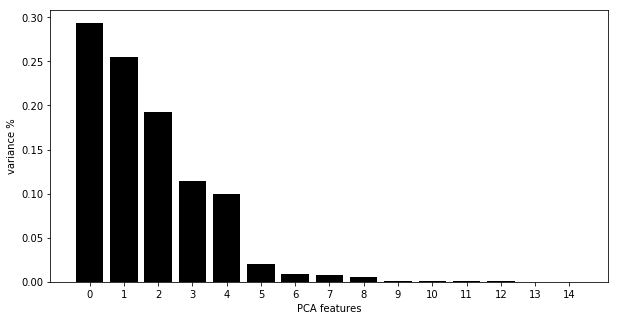

In [33]:
# Plot the explained variances
plt.figure(figsize=(10, 5))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [34]:
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

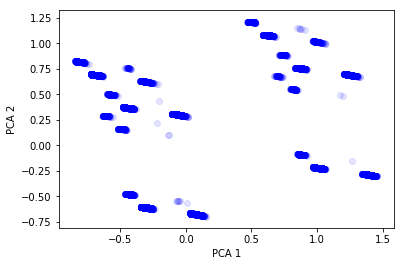

In [35]:
plt.figure(figsize = (6,4))
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color=('blue'))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

The above figure shows at least 4 distinguishable clusters. So, let's hope that the data in this dataset can be grouped.Now, Let's check the minimum number of principal components such that 95% variance is retained.

In [36]:
pca = PCA(0.95)
x_pca = pca.fit_transform(df_train.loc[:, df_train.columns != 'user_id'])

In [37]:
pca.n_components_

5

### t-Distributed Stochastic Neighbouring Entities (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. Contrary to PCA it is not a mathematical technique but a probablistic one.

In [38]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)

In [39]:
tsne_results = tsne.fit_transform(df_train.loc[:, df_train.columns != 'user_id'])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 91846 samples in 4.645s...
[t-SNE] Computed neighbors for 91846 samples in 222.643s...
[t-SNE] Computed conditional probabilities for sample 1000 / 91846
[t-SNE] Computed conditional probabilities for sample 2000 / 91846
[t-SNE] Computed conditional probabilities for sample 3000 / 91846
[t-SNE] Computed conditional probabilities for sample 4000 / 91846
[t-SNE] Computed conditional probabilities for sample 5000 / 91846
[t-SNE] Computed conditional probabilities for sample 6000 / 91846
[t-SNE] Computed conditional probabilities for sample 7000 / 91846
[t-SNE] Computed conditional probabilities for sample 8000 / 91846
[t-SNE] Computed conditional probabilities for sample 9000 / 91846
[t-SNE] Computed conditional probabilities for sample 10000 / 91846
[t-SNE] Computed conditional probabilities for sample 11000 / 91846
[t-SNE] Computed conditional probabilities for sample 12000 / 91846
[t-SNE] Computed conditional probabilities for 

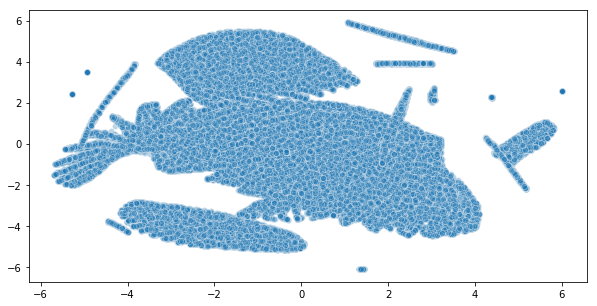

In [40]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    #hue = 'days_order_span',
    palette=sns.color_palette("hls", 10),
    data=df_train.loc[:, df_train.columns != 'user_id'],
    legend="full",
    alpha=0.3
)

### Find the Clusters

#### 1. Elbow-Method to determine Cluster Numbers

Elbow method gives us an idea on what a good k number of clusters would be based on the sum of squared distance (SSE) between data points and their assigned clusters’ centroids.

In [41]:
plt.figure(figsize=(10, 8))
sum_of_squared_distances = []

for i in range(1, 30):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_train.loc[:, df_train.columns != 'user_id'])
    sum_of_squared_distances.append(kmeans.inertia_)

<Figure size 720x576 with 0 Axes>

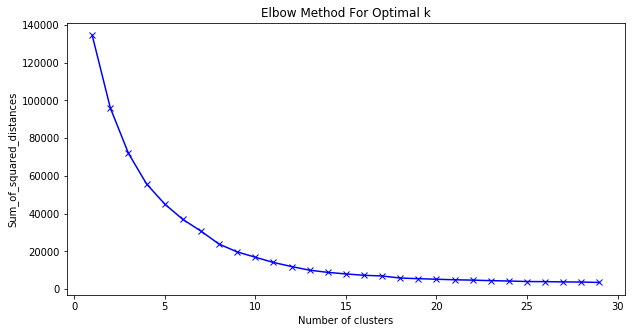

In [42]:
plt.figure(figsize=(10,5))
plt.plot(range(1, 30), sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The plot from the above Elbow Method is not giving a clear picture of Cluster Size. Let's try some other method.

#### 2. Silhouette-Method to determine Cluster Numbers

Silhouette Method is a way to measure how close each point in a cluster is to the points in its neighboring clusters. Its a way to find out the optimum value for k during k-means clustering

In [43]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(df_train.loc[:, df_train.columns != 'user_id'])
  labels = kmeans.labels_
  sil.append(silhouette_score(df_train.loc[:, df_train.columns != 'user_id'], labels, metric = 'euclidean'))

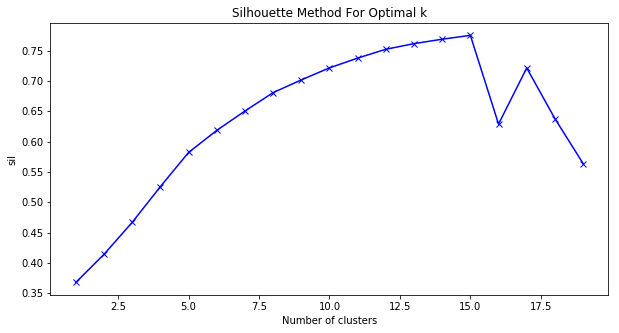

In [44]:
plt.figure(figsize=(10,5))
plt.plot(range(1, 20), sil, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('sil')
plt.title('Silhouette Method For Optimal k')
plt.show()

## Customer Classification Using K-Means Clustering

Similar customers like similar products. Based on the t-SNE plot and the Silhoute Plot, let's categorize the customers into 5 categories. Then, we will see the top 10 products from each category of customers. 
<br>Finally, we are going to recommend the products customer category wise.
<br> So, let's use **K-Means** Algorithm for cutomer classifications. 

### Fitting K-Means Algorithm

In [45]:
# Fitting K-Means to the standarized dataset
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
y_kmeans = kmeans.fit(df_train.loc[:, df_train.columns != 'user_id'])

In [46]:
labels = y_kmeans.labels_
labels = pd.DataFrame(labels)
df_train['kmeans_cluster'] = labels
df_train.head()

/Users/oindrilasen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,days_order_span,days_since_prior_order,order_size,total_order_count,alcohol,babies,beverages,food,household,...,weekend_buy_1,preferred_hour_1,preferred_hour_2,preferred_hour_3,preferred_hour_4,prefers_organic_0,prefers_organic_1,loyal_customer_0,loyal_customer_1,kmeans_cluster
0,1,0.057490,0.600000,0.078947,0.072917,0.0,0.0,0.012876,0.019638,0.008427,...,1,0,1,0,0,1,0,1,0,3
1,2,0.176709,0.566667,0.223684,0.114583,0.0,0.0,0.007725,0.077397,0.000000,...,1,0,1,0,0,1,0,1,0,3
2,5,0.019854,0.300000,0.118421,0.010417,0.0,0.0,0.000000,0.014632,0.002809,...,1,0,0,1,0,0,1,1,0,0
3,7,0.123549,0.400000,0.157895,0.177083,0.0,0.0,0.048069,0.056604,0.002809,...,1,0,0,1,0,1,0,1,0,1
4,8,0.046987,0.500000,0.210526,0.000000,0.0,0.0,0.000000,0.023874,0.000000,...,0,0,0,0,1,0,1,1,0,0


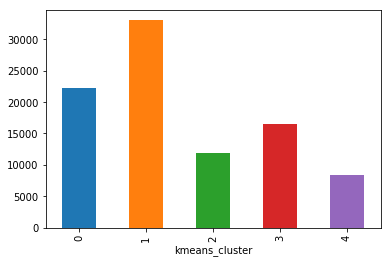

In [47]:
df_train.groupby("kmeans_cluster")["user_id"].count().plot("bar")

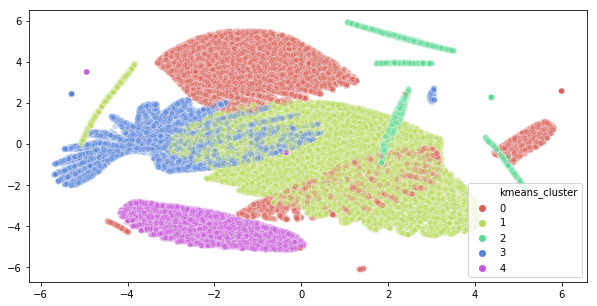

In [48]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue='kmeans_cluster',
    palette=sns.color_palette("hls", 5),
    data=df_train.loc[:, df_train.columns != 'user_id'],
    legend="full",
    alpha=0.3
)

From this plot, Cluster1 covers the major portion. And some points are mixed up. Let's see if we can recommend products based on clusters.

### Prediction using K-Means

In [49]:
df_test.head(2)

,user_id,days_order_span,days_since_prior_order,order_size,total_order_count,alcohol,babies,beverages,food,household,...,weekend_buy_0,weekend_buy_1,preferred_hour_1,preferred_hour_2,preferred_hour_3,preferred_hour_4,prefers_organic_0,prefers_organic_1,loyal_customer_0,loyal_customer_1
91847,144525,0.080569,0.400000,0.236842,0.041667,0.0,0.0,0.007725,0.044282,0.011236,...,0,1,0,0,0,1,0,1,1,0
91848,144527,0.052331,0.766667,0.052632,0.093750,0.0,0.0,0.021459,0.005776,0.002809,...,0,1,0,1,0,0,1,0,1,0


In [50]:
kmeans_values = y_kmeans.predict(df_test.loc[:, df_test.columns != 'user_id'])

In [51]:
kmeans_values

array([0, 3, 3, ..., 0, 0, 1], dtype=int32)

/Users/oindrilasen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


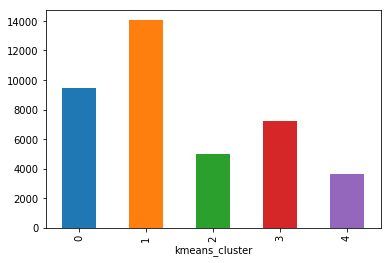

In [52]:
kmeans_cluster = pd.DataFrame(kmeans_values)
df_test['kmeans_cluster'] = kmeans_cluster.values
df_test.groupby("kmeans_cluster")["user_id"].count().plot("bar")

**Add Cluster to the Original Dataset**

In [53]:
df_final_train = pd.merge(df_final,df_train[["user_id","kmeans_cluster"]], on = 'user_id')

In [54]:
df_final_train["user_id"].nunique()

91846

In [55]:
df_final_train.head(2)

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,dept_group,...,total_order_count,loyal_customer,days_order_span,user_dept_count,user_product_count,weekend_buy,preferred_hour,is_organic,prefers_organic,kmeans_cluster
0,16844148,2539329,196,1,0,soda,77,7,soft-drinks,beverages,...,11,False,1248.0,15,11,False,1,False,0,3
1,16844134,2539329,14084,2,0,organic-unsweetened-vanilla-almond-milk,91,16,soy-lactosefree,food,...,11,False,1248.0,51,1,False,1,True,0,3


#### Cluster 0 - Top 10 Products

In [56]:
df_final_train[df_final_train.kmeans_cluster == 0]['product_name'].value_counts().sort_values(ascending = False).to_frame()[:10]

,product_name
bag-of-organic-bananas,57882
organic-strawberries,38401
organic-baby-spinach,38339
organic-hass-avocado,34874
banana,28708
organic-avocado,22541
organic-raspberries,20233
organic-whole-milk,19281
organic-yellow-onion,19256
organic-garlic,18271


#### Cluster 2- Top 10 Products

In [57]:
df_final_train[df_final_train.kmeans_cluster == 2]['product_name'].value_counts().sort_values(ascending = False).to_frame()[:10]

,product_name
banana,94847
bag-of-organic-bananas,83953
organic-strawberries,60766
organic-hass-avocado,50338
organic-baby-spinach,48201
organic-whole-milk,32932
organic-raspberries,32892
organic-avocado,31478
large-lemon,27476
limes,27423


### Conclusion:

Top 10 Products from both the Clusters are same which is not very convinient Model for Recommendations. But again, Food is the Most Popular products that the Customers ordered quite frequently. 

Let's take a final look for top 10 products from each cluster apart from food department.

In [58]:
#df_final_train[(df_final_train.kmeans_cluster == 4) & (df_final_train.dept_group != "food")]['product_name'].value_counts().sort_values(ascending = False).to_frame()[:10]

| Cluster0  |   Cluster1  | Cluster2  | Cluster3  |  Cluster4  |
|-----------|:-----------:|:----------:|:----------:|-----------:|
|sparkling-water-grapefruit|sparkling-water-grapefruit |sparkling-water-grapefruit |sparkling-water-grapefruit |sparkling-water-grapefruit|
|spring-water|soda|soda |spring-water |spring-water|
|extra-virgin-olive-oil	|lime-sparkling-water |spring-water |soda|extra-virgin-olive-oil|
|100%-raw-coconut-water|spring-water |lime-sparkling-water |lime-sparkling-water|100%-raw-coconut-water|
|sparkling-natural-mineral-water|sparkling-natural-mineral-water |extra-virgin-olive-oil|sparkling-natural-mineral-water|sparkling-natural-mineral-water|
|italian-sparkling-mineral-water|sparkling-lemon-water|sparkling-natural-mineral-water |extra-virgin-olive-oil |lime-sparkling-water|
|lime-sparkling-water|extra-virgin-olive-oil|sparkling-lemon-water |sparkling-lemon-water |italian-sparkling-mineral-water|
|100%-recycled-paper-towels|sparkling-mineral-water |original-orange-juice|fridge-pack-cola |100%-recycled-paper-towels|
|organic-raw-kombucha-gingerade|pure-sparkling-water |creamy-peanut-butter|creamy-peanut-butter |sparkling-lemon-water|	
|organic-creamy-peanut-butter| original-orange-juice|pure-sparkling-water|natural-spring-water |pure-sparkling-water|



Again the top 10 products are more or less same from all the clusters and most of the products belogs to "beverages".
May be Customer Classification is not a great approach for recommendations using the current dataset!

## Customer Classification Using K-Modes Clustering

The basic concept of k-means stands on mathematical calculations (means, euclidian distances). But, in our case, most of the features are Categorical. May be that's the reason why our above customer classification using K-Means didn't work well.
<br>Let's give a try to **k-modes** algorithm which is an extension of k-means. Instead of distances it uses dissimilarities (that is, quantification of the total mismatches between two objects: the smaller this number, the more similar the two objects). And instead of means, it uses **modes**.

#### Prepare the Dataset

In [59]:
df5 =  df3.pivot_table(index = "user_id",columns='dept_group', values = "value_present", fill_value=0)
df5 =  df5.reset_index()
#df5[df5.user_id == 1]

In [60]:
df_cat = pd.merge(df1,df2, on ='user_id')
df_cat = pd.merge(df_cat,df5, on ='user_id')
df_cat.head(2)

,user_id,weekend_buy,preferred_hour,prefers_organic,loyal_customer,days_order_span,days_since_prior_order,order_size,total_order_count,alcohol,babies,beverages,food,household,international,other,pantry,personal-care,pets
0,1,1,2,0,0,1248.0,18.0,7.0,11.0,0,0,1,1,1,0,0,1,0,0
1,2,1,2,0,0,3836.0,17.0,18.0,15.0,0,0,1,1,0,1,0,1,1,0


#### Standardizing Data

In [61]:
columns_to_normalize     = ['days_order_span','days_since_prior_order','order_size','total_order_count']
df_cat[columns_to_normalize] = df_cat[columns_to_normalize].apply(lambda x: ((x - x.min()) / (x.max() - x.min())))

#### Divide Dataset into Training and Test Set

In [62]:
## Divide Dataset into Train and Test Set
df_cat_train = df_cat.head(int(len(df_cat)*(70/100)))
df_cat_test  = df_cat.tail(int(len(df_cat)*(30/100)))

#### Fitting K-Modes Algorithm

In [63]:
km = KModes(n_clusters=5, init='Huang', n_init=5, verbose=1)
clusters = km.fit(df_cat_train.loc[:, df_cat_train.columns != 'user_id'])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 30379, cost: 534288.0
Run 1, iteration: 2/100, moves: 0, cost: 534288.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 38152, cost: 527619.0
Run 2, iteration: 2/100, moves: 153, cost: 527619.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 25344, cost: 534998.0
Run 3, iteration: 2/100, moves: 10398, cost: 534998.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 31387, cost: 532172.0
Run 4, iteration: 2/100, moves: 14919, cost: 530384.0
Run 4, iteration: 3/100, moves: 60, cost: 530384.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 37904, cost: 529372.0
Run 5, iteration: 2/100, moves: 2309, cost: 529372.0
Best run was num

In [64]:
km_labels = clusters.labels_
km_labels = pd.DataFrame(km_labels)
df_cat_train['km_cluster'] = km_labels

/Users/oindrilasen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


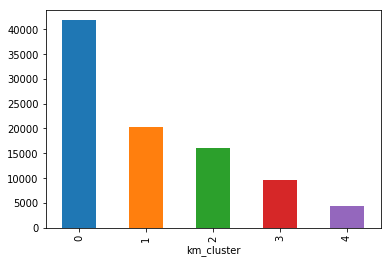

In [65]:
#df_train.kmodes_cluster.value_counts().plot("bar")
df_cat_train.groupby("km_cluster")["user_id"].count().plot("bar")

In [69]:
time_start = time.time()
tsne_new = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)

In [70]:
tsne_results_new = tsne_new.fit_transform(df_cat_train.loc[:, df_cat_train.columns != 'user_id'])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 91846 samples in 6.994s...
[t-SNE] Computed neighbors for 91846 samples in 255.158s...
[t-SNE] Computed conditional probabilities for sample 1000 / 91846
[t-SNE] Computed conditional probabilities for sample 2000 / 91846
[t-SNE] Computed conditional probabilities for sample 3000 / 91846
[t-SNE] Computed conditional probabilities for sample 4000 / 91846
[t-SNE] Computed conditional probabilities for sample 5000 / 91846
[t-SNE] Computed conditional probabilities for sample 6000 / 91846
[t-SNE] Computed conditional probabilities for sample 7000 / 91846
[t-SNE] Computed conditional probabilities for sample 8000 / 91846
[t-SNE] Computed conditional probabilities for sample 9000 / 91846
[t-SNE] Computed conditional probabilities for sample 10000 / 91846
[t-SNE] Computed conditional probabilities for sample 11000 / 91846
[t-SNE] Computed conditional probabilities for sample 12000 / 91846
[t-SNE] Computed conditional probabilities for 

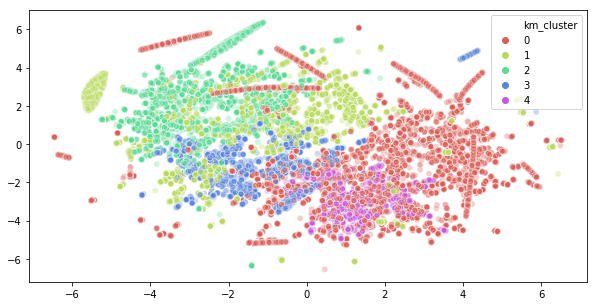

In [71]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    x=tsne_results_new[:,0], y=tsne_results_new[:,1],
    hue='km_cluster',
    palette=sns.color_palette("hls", 5),
    data=df_cat_train.loc[:, df_cat_train.columns != 'user_id'],
    legend="full",
    alpha=0.3
)

Here, all the data points in different cluster is very difficult to separate.

### Prediction using K-Mode

/Users/oindrilasen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


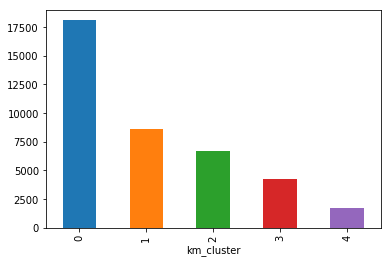

In [72]:
km_values = km.predict(df_cat_test.iloc[:,1:25])
km_cluster = pd.DataFrame(km_values)
df_cat_test['km_cluster'] = km_cluster.values
df_cat_test.groupby("km_cluster")["user_id"].count().plot("bar")

#### Add Cluster to the Original Dataset

In [74]:
df_final_train = pd.merge(df_final,df_cat_train[["user_id","km_cluster"]], on = 'user_id')

#### Cluster 0 - Top 10 Products from Departments other than Food

In [75]:
df_final_train[(df_final_train.km_cluster == 0) & (df_final_train.dept_group != "food")]['product_name'].value_counts().sort_values(ascending = False).to_frame()[:10]

,product_name
sparkling-water-grapefruit,10184
soda,9288
spring-water,8182
lime-sparkling-water,6477
extra-virgin-olive-oil,5763
sparkling-natural-mineral-water,4724
sparkling-lemon-water,4377
100%-raw-coconut-water,4034
creamy-almond-butter,3846
sparkling-mineral-water,3587


#### Cluster 1- Top 10 Products from Departments other than Food

In [76]:
df_final_train[(df_final_train.km_cluster == 1) & (df_final_train.dept_group != "food")]['product_name'].value_counts().sort_values(ascending = False).to_frame()[:10]

,product_name
sparkling-water-grapefruit,12057
extra-virgin-olive-oil,8931
spring-water,8788
sparkling-natural-mineral-water,7357
lime-sparkling-water,7128
100%-raw-coconut-water,6879
100%-recycled-paper-towels,6042
italian-sparkling-mineral-water,5995
sparkling-lemon-water,5241
pure-sparkling-water,4496


Again the top 10 products are more or less same for both the clusters.

## Customer Classification Using K-Prototype Clustering

In [77]:
df_cat_train.iloc[:, 1:19].head(2)

,weekend_buy,preferred_hour,prefers_organic,loyal_customer,days_order_span,days_since_prior_order,order_size,total_order_count,alcohol,babies,beverages,food,household,international,other,pantry,personal-care,pets
0,1,2,0,0,0.057490,0.600000,0.078947,0.072917,0,0,1,1,1,0,0,1,0,0
1,1,2,0,0,0.176709,0.566667,0.223684,0.114583,0,0,1,1,0,1,0,1,1,0


### Fitting K-Prototype Algorithm

In [78]:
# Running K-Prototype clustering
kprototype = KPrototypes(n_clusters=5, init='Huang', n_init=5)
kp_clusters = kprototype.fit(df_cat_train.iloc[:, 1:19], categorical=[0,1,2,3,8,9,10,11,12,13,14,15,16,17])

In [79]:
kp_labels = kprototype.labels_
kp_labels = pd.DataFrame(kp_labels)
df_cat_train['kp_cluster'] = kp_labels

/Users/oindrilasen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


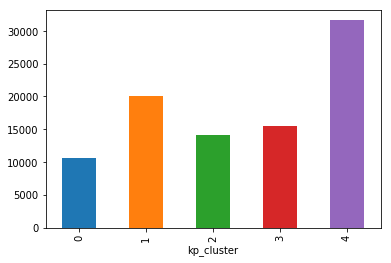

In [80]:
df_cat_train.groupby("kp_cluster")["user_id"].count().plot("bar")

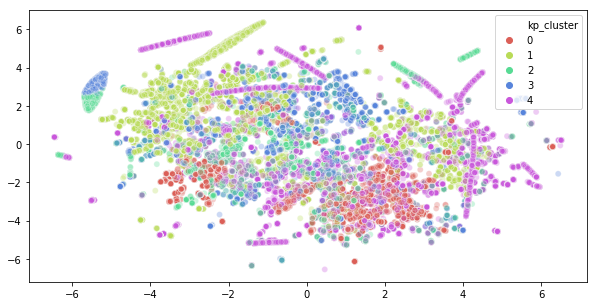

In [83]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    x=tsne_results_new[:,0], y=tsne_results_new[:,1],
    hue='kp_cluster',
    palette=sns.color_palette("hls", 5),
    data=df_cat_train.loc[:, df_cat_train.columns != 'user_id'],
    legend="full",
    alpha=0.3
)

#### Add Cluster to the Original Dataset

In [84]:
df_final_train = pd.merge(df_final,df_cat_train[["user_id","kp_cluster"]], on = 'user_id')

#### Cluster 0 - Top 10 Products from Departments other than Food

In [85]:
df_final_train[(df_final_train.kp_cluster == 0) & (df_final_train.dept_group != "food")]['product_name'].value_counts().sort_values(ascending = False).to_frame()[:10]

,product_name
sparkling-water-grapefruit,14141
spring-water,11638
extra-virgin-olive-oil,9447
100%-raw-coconut-water,8964
sparkling-natural-mineral-water,8637
lime-sparkling-water,8432
italian-sparkling-mineral-water,6763
sparkling-lemon-water,6433
pure-sparkling-water,6117
100%-recycled-paper-towels,5552


#### Cluster 1 - Top 10 Products from Departments other than Food

In [86]:
df_final_train[(df_final_train.kp_cluster == 1) & (df_final_train.dept_group != "food")]['product_name'].value_counts().sort_values(ascending = False).to_frame()[:10]

,product_name
sparkling-water-grapefruit,4513
spring-water,3951
soda,3788
sparkling-natural-mineral-water,3667
lime-sparkling-water,3397
extra-virgin-olive-oil,3097
sparkling-lemon-water,2771
100%-recycled-paper-towels,2417
fridge-pack-cola,2378
creamy-peanut-butter,2251


Hmmm, so the type of products ordered by the customers are more or less same. 

## Final Conclusion:

In this notebook, we have tried different Clustering Algorithms to classify customers. But, with the current dataset, the Customers order similar products. For Example, at Instacart most of the customers order Food and Beverages. So, it is difficult to classify Customer based on their ordering behavior.

May be the above approaches would have worked in some other online shopping portals where there is a broad range of products and we could have cllasified the customers based on the shopping history. 

For this dataset, let's conclude that the traditional Recommendation Algorithms like **ALS** and **Cosine Similarity** are better choices.